# Scaling Plot – Micro‑Benchmark  
Loads the latest **qr-bench-micro** run from Weights & Biases and plots log‑log
scaling of *(i) forward+backward* vs *(ii) optimizer.step()* time.

> **Tip:** If you'd rather use local CSV/JSON, change the `LOAD_FROM_WANDB`
> flag in Cell 2.


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, re, os, math
import wandb

# --------------------------------------------------
# Configuration
# --------------------------------------------------
PROJECT = "micro-bench"  # wandb project name
LOAD_FROM_WANDB = True  # set False to read a local JSON instead
LOCAL_JSON = "bench_latest.json"  # fallback file
SPECIFIC_RUN_ID = "dion-1.0"  # replace with actual run ID or None


def get_data(run_id=None):
    if LOAD_FROM_WANDB:
        api = wandb.Api()
        if run_id:
            run = api.run(f"{PROJECT}/{run_id}")
            print(
                f"Loaded specific run: {run.name} ({run.id}) – created {run.created_at}"
            )
        else:
            runs = api.runs(PROJECT)
            if not runs:
                raise RuntimeError(f"No runs found in project {PROJECT!r}")
            run = max(runs, key=lambda r: r.created_at)
            print(
                f"Loaded latest run: {run.name} ({run.id}) – created {run.created_at}"
            )

        hist = run.history()
        rows = []
        for col in hist.columns:
            if col.endswith("/opt_ms") or col.endswith("/fb_ms"):
                model, what = col.split("/")
                rows.append(
                    dict(model=model, what=what, value=hist[col].dropna().iloc[-1])
                )
        df_long = pd.DataFrame(rows)
    else:
        df_long = pd.read_json(LOCAL_JSON)

    df = df_long.pivot(index="model", columns="what", values="value").reset_index()
    param_map = {
        "60M": 60e6,
        "120M": 120e6,
        "350M": 350e6,
        "760M": 760e6,
        "1.3B": 1.3e9,
        "2.7B": 2.7e9,
        "5B": 5e9,
    }
    df["params"] = df["model"].map(param_map)
    return df.sort_values("params")


# Example usage:
df = get_data(run_id=SPECIFIC_RUN_ID)
df

Loaded run dion-micro-dbda (kju2sk99) – created 2025-05-28T18:12:23Z


what,model,fb_ms,opt_ms,params
4,60M,412.814219,1004.777344,6.000000e+07
1,120M,1290.575547,2361.913281,1.200000e+08
3,350M,6107.794375,6710.338750,3.500000e+08
5,760M,22803.185000,12683.038750,7.600000e+08
0,1.3B,66044.790000,19521.493750,1.300000e+09
2,2.7B,156803.380000,38639.655000,2.700000e+09


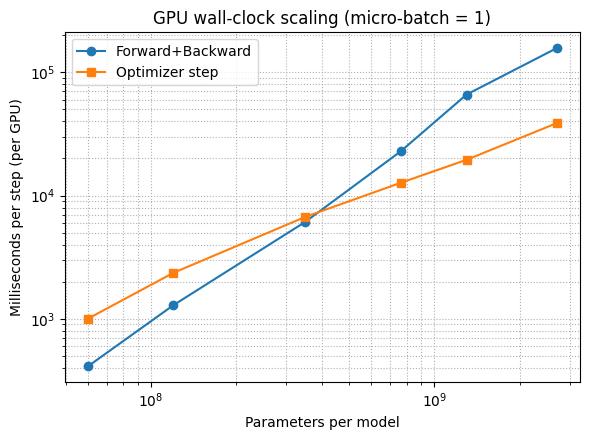

In [5]:
plt.figure(figsize=(6, 4.5))
plt.loglog(df["params"], df["fb_ms"], marker="o", label="Forward+Backward")
plt.loglog(df["params"], df["opt_ms"], marker="s", label="Optimizer step")
plt.xlabel("Parameters per model")
plt.ylabel("Milliseconds per step (per GPU)")
plt.title("GPU wall‑clock scaling (micro‑batch = 1)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
for col in ["fwd_bwd_ms", "opt_ms"]:
    slope, intercept = np.polyfit(np.log10(df["params"]), np.log10(df[col]), 1)
    print(f"{col}: time ∝ params^{slope:.2f}")

fwd_bwd_ms: time ∝ params^0.23
opt_ms: time ∝ params^0.87
